### **Задание №1**. Предположим, что у вас в базе есть табличка с балансом по всем счетам клиента на конец дня. Из-за особенностей построения таблицы, часть значений незаполнена и физически это означает отсутствие информации об изменении баланса. Для простоты будем считать, пропущенные значения для одного пользователя не могут встретиться между двумя заполненными. Напишите SQL запрос для заполнения неизвестных значений по каждому клиенту последним известным.

client_id |date | value
--- | --- | ---
1 | 14.04.2020 | 10000
1 | 15.04.2020 | 5000
1 | 16.04.2020 | NaN
1 | 17.04.2020 | NaN
1 | 18.04.2020 | NaN
2 | 14.04.2020 | 250000
2 | 15.04.2020 | 250000
2 | 16.04.2020 | 230000
2 | 17.04.2020 | 230000
2 | 18.04.2020 | 225000
3 | 14.04.2020 | 50000
3 | 15.04.2020 | NaN
3 | 16.04.2020 | NaN
3 | 17.04.2020 | NaN
3 | 18.04.2020 | NaN


In [ ]:
UPDATE client
SET value = (@v := COALESCE(value, @v))
ORDER BY client_id;

#### Результат:
client_id |date | value
--- | --- | ---
1 | 14.04.2020 | 10000
1 | 15.04.2020 | 5000
1 | 16.04.2020 | 5000
1 | 17.04.2020 | 5000
1 | 18.04.2020 | 5000
2 | 14.04.2020 | 250000
2 | 15.04.2020 | 250000
2 | 16.04.2020 | 230000
2 | 17.04.2020 | 230000
2 | 18.04.2020 | 225000
3 | 14.04.2020 | 50000
3 | 15.04.2020 | 50000
3 | 16.04.2020 | 50000
3 | 17.04.2020 | 50000
3 | 18.04.2020 | 50000

### **Задание №1.1 (*)**. В прошлом задании мы считали, что пропущенные значения не могут находиться между двумя заполненными в рамках одного пользователя, что не всегда правда в реальных задачах. Напишите теперь SQL запрос без указанного допущения.

client_id |date | value
--- | --- | ---
1 | 14.04.2020 | 10000
1 | 15.04.2020 | 5000
1 | 16.04.2020 | NaN
1 | 17.04.2020 | 7000
1 | 18.04.2020 | NaN
2 | 14.04.2020 | 250000
2 | 15.04.2020 | 250000
2 | 16.04.2020 | 230000
2 | 17.04.2020 | 230000
2 | 18.04.2020 | 225000
3 | 14.04.2020 | 50000
3 | 15.04.2020 | NaN
3 | 16.04.2020 | NaN
3 | 17.04.2020 | 49000
3 | 18.04.2020 | NaN

Отберем последние известные значения для каждого клиента:

In [ ]:
CREATE TABLE new_table LIKE client;
INSERT INTO new_table
SELECT *
FROM (SELECT *
      FROM client
      WHERE value IS NOT NULL) AS t
WHERE (t.client_id, t.data) IN (SELECT t.client_id, MAX(t.data) FROM (SELECT *
      FROM client
      WHERE value IS NOT NULL) AS t GROUP BY t.client_id);

Вот так выглядит new_table:

client_id |date | value
--- | --- | ---
1 | 17.04.2020 | 7000
2 | 18.04.2020 | 225000
3 | 17.04.2020 | 49000

Запрос на заполнение Null последним известным значением для клиента:

In [ ]:
UPDATE client AS c1, new_table AS c2
SET c1.value = c2.value
WHERE c1.value IS NULL AND c1.client_id = c2.client_id;

#### Результат
client_id |date | value
--- | --- | ---
1 | 14.04.2020 | 10000
1 | 15.04.2020 | 5000
1 | 16.04.2020 | 7000
1 | 17.04.2020 | 7000
1 | 18.04.2020 | 7000
2 | 14.04.2020 | 250000
2 | 15.04.2020 | 250000
2 | 16.04.2020 | 230000
2 | 17.04.2020 | 230000
2 | 18.04.2020 | 225000
3 | 14.04.2020 | 50000
3 | 15.04.2020 | 49000
3 | 16.04.2020 | 49000
3 | 17.04.2020 | 49000
3 | 18.04.2020 | 49000

### **Задание №2**. Пусть клиенты обладают рядом статусов, закодированных цифрами: 0 - "улица", 1 - "зарплатник", 2 - "премиум", 3 - "пенсионер", 4 - "студент". У нас есть матрица с логами смен статусов за некоторый период, разверните ее в матрицу статус - статус с частотами перехода между ними.

Пример, как было:

client_id | prev_segment | new_segment|
--- | --- | ---
1 | 0 | 1
2 | 0 | 2
3 | 4 | 3

Пример, как нужно:

segment |0 | 1 | 2 | 3 | 4 
--- | --- | --- | --- | --- | ---
0 | 0 | 0.5 | 0.5 | 0 | 0 
1 | 0 |0 | 0 | 0 | 0
2 | 0 | 0 | 0 | 0 | 0
3 | 0 | 0 | 0 | 0 | 0
4 | 0 | 0 | 0 | 1 | 0

В процессе выполнения задания разрешается пользоваться библиотеками numpy и pandas.

In [ ]:
import numpy as np
import pandas as pd


# Сгенерируем данные для задачи
data = pd.DataFrame(
     np.random.randint(low=0, high=5, size=(500000, 2)),
     columns=['prev_segment', 'new_segment']
)

df = pd.crosstab(data.prev_segment,
            data.new_segment,
            normalize='index')
df.columns = ['0', '1', '2', '3', '4']
df.index.names = ['segment']
df

,0,1,2,3,4
segment,,,,,
0,0.201442,0.200640,0.198504,0.199216,0.200198
1,0.201521,0.201941,0.199930,0.198509,0.198099
2,0.199727,0.201232,0.200690,0.199406,0.198945
3,0.201119,0.198376,0.198964,0.202327,0.199214
4,0.201775,0.199564,0.201028,0.198060,0.199574


### **Задание №3**. Постройте прогнозую модель для датасета с UCI Machine Learning: предобработайте категориальные фичи, отберите их, соберите схему валидации и отберите модели с помощью нее. Описание датасета по ссылке: https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

Данная задача multilabel multiclass classification, поэтому предлагаю начать с одного из подходов:
- Свести задачу к multilabel binary classification, как это указано в описании к датасету;
- Свести задачку к binary classification тем или иным способом;
- Обучить множество multiclass/binary classification моделей;
- Что-то еще, что придет в голову.


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data

--2021-07-26 14:15:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346695 (339K) [application/x-httpd-php]
Saving to: ‘drug_consumption.data.13’

drug_consumption.da 100%[===================>] 338.57K  1.26MB/s    in 0.3s    

2021-07-26 14:15:14 (1.26 MB/s) - ‘drug_consumption.data.13’ saved [346695/346695]



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import preprocessing
from sklearn.metrics import precision_score
warnings.filterwarnings("ignore")
plt.style.use(style='ggplot')

In [ ]:
data = pd.read_csv('drug_consumption.data', header=None, index_col=0)
data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885 entries, 1 to 1888
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       1885 non-null   float64
 1   2       1885 non-null   float64
 2   3       1885 non-null   float64
 3   4       1885 non-null   float64
 4   5       1885 non-null   float64
 5   6       1885 non-null   float64
 6   7       1885 non-null   float64
 7   8       1885 non-null   float64
 8   9       1885 non-null   float64
 9   10      1885 non-null   float64
 10  11      1885 non-null   float64
 11  12      1885 non-null   float64
 12  13      1885 non-null   object 
 13  14      1885 non-null   object 
 14  15      1885 non-null   object 
 15  16      1885 non-null   object 
 16  17      1885 non-null   object 
 17  18      1885 non-null   object 
 18  19      1885 non-null   object 
 19  20      1885 non-null   object 
 20  21      1885 non-null   object 
 21  22      1885 non-null   object 
 22  

Пропусков в данных нет

Посмотрим различные статистики

In [ ]:
data.describe()

,1,2,3,4,5,6,7,8,9,10,11,12
count,1885.00000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,0.03461,-0.000256,-0.003806,0.355542,-0.309577,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,0.87836,0.482588,0.950078,0.700335,0.166226,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,-0.95197,-0.482460,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,-0.95197,-0.482460,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,-0.07854,-0.482460,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,0.49788,0.482460,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,2.59171,0.482460,1.984370,0.960820,1.907250,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


# Data preprocessing

In [ ]:
columns = ['age', 'gender', 'education', 'country',
'ethnicity', 'neuroticism', 'extraversion', 'openness',
'agreeableness','conscientiousness', 'impulsiveness', 
'sensation', 'alcohol', 'amphet', 'amyl', 'benzos', 'caffeine', 
'cannabis', 'chocolate', 'cocaine', 'crack', 'ecstasy', 
'heroin', 'ketamine', 'legalh', 'lsd', 
'meth', 'mushrooms', 'nicotine', 'semer', 'vsa']
data.columns = columns

In [ ]:
data = data.reset_index(drop=True)

Сведем задачу к бинарной классификации, будем считать, что если человек не употреблял вещество или употреблял более десяти лет назад (класс 0), то он не наркоман, иначе - человек, болеющий таким заболеванием (класс 1)

In [ ]:
data = data.replace({'CL0' : 0, 'CL1' : 0, 'CL2' : 1, 'CL3' : 1, 'CL4' : 1, 'CL5' : 1, 'CL6' : 1})

In [ ]:
data.head()

,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation,alcohol,amphet,amyl,benzos,caffeine,cannabis,chocolate,cocaine,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1,1,1,0,1,1,1,1,0,1,0,1,0,1,1,0,1,0,0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,1,0,0,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0


Можем посмотреть на колонки с веществами и заметить интересную вещь, что в них есть такие вещества как алкоголь, кофеин, который есть в кофе, и шоколад, посмотрим на количество не употреблявших данные вещества людей

In [ ]:
drugs = list(data.columns)[12:]
drug_values = []
for drug in drugs:
    drug_values.append((data[drug].value_counts()[0], drug))
drug_values = sorted(drug_values)
drug_values[:10]

[(35, 'chocolate'),
 (37, 'caffeine'),
 (68, 'alcohol'),
 (620, 'cannabis'),
 (621, 'nicotine'),
 (1116, 'benzos'),
 (1123, 'legalh'),
 (1134, 'ecstasy'),
 (1191, 'mushrooms'),
 (1198, 'cocaine')]

Как видно, количество людей не употреблявших алкоголь, кофеин и шоколад очень маленькое, и это объяснимо, ведь это не наркотические вещества, а вещества, которые употребляют в обыденности здоровые люди

Удалим эти признаки, так как не совсем корректно относить такую большую выборку людей к наркоманам, если они употребляют три этих вещества

In [ ]:
data = data.drop(columns=['alcohol', 'caffeine', 'chocolate'], axis=1)

In [ ]:
drugs.remove('alcohol')
drugs.remove('caffeine')
drugs.remove('chocolate')

In [ ]:
data['use_drugs'] = list(map(lambda x: 1 if sum(x) > 0 else 0, data[drugs].values))

In [ ]:
data = data.drop(drugs, axis=1)

In [ ]:
X = list(data.columns)[:-1]

In [ ]:
data[X] = data[X].astype(str)

In [ ]:
data['age'] = data['age'].replace({'-0.9519700000000001': '18-24', '-0.07854': '25-34', '0.49788000000000004': '35-44', '1.09449': '45-54', '1.82213': '55-64', '2.59171': '65+'})

In [ ]:
data['gender'] = data['gender'].replace({'-0.48246000000000006': 'Male', '0.48246000000000006': 'Female'})

In [ ]:
data['education'] = data['education'].replace({'-0.6111300000000001': 'Educ_without_degree', '0.45468000000000003': 'University_degree', '1.16365': 'Masters_degree',
                                            '-0.059210000000000006': 'Professional_diploma', '-1.22751': 'Left_school_at_18_years', '-1.7379': 'Left_school_at_16_years',
                                            '1.98437': 'Doctorate_degree', '-1.43719': 'Left_school_at_17 years', '-2.43591': 'Left_school_before_16_years'})

In [ ]:
data['country'] = data['country'].replace({'0.9608200000000001': 'UK', '-0.57009': 'USA', '-0.28519': 'Other', '0.24923': 'Canada',
                                           '-0.09765': 'Australia', '0.21128000000000002': 'Republic_of_Ireland', '-0.46841000000000005': 'New_Zealand'})

In [ ]:
data['ethnicity'] = data['ethnicity'].replace({'-0.31685': 'White', '0.1144': 'Other', '-1.1070200000000001': 'Black', '-0.50212': 'Asian',
                                               '-0.22166': 'Mixed-White/Black', '0.126': 'Mixed-White/Asian', '1.90725': 'Mixed-Black/Asian'})

In [ ]:
data['neuroticism'] = data['neuroticism'].replace({'-0.46725': 31, '0.41667': 40, '-0.34799': 32, '0.62967': 42, '-0.14882': 34, '0.04257': 36, '-0.79151': 28,
                                                      '-0.051879999999999996': 35, '-0.24649000000000001': 33, '1.02119': 46, '0.13606': 37, '0.31287': 39, 
                                                      '-0.92104': 27, '0.22393000000000002': 38, '-0.58016': 30, '0.52135': 41, '-0.67825': 29, '-1.05308': 26, 
                                                      '-1.1943': 25, '0.82562': 44, '1.23461': 48, '0.73545': 43, '1.37297': 49, '0.9109299999999999': 45, '-1.32828': 24, 
                                                      '-1.69163': 21, '-1.43907': 23, '1.13281': 47, '1.6038299999999999': 51, '-1.5507799999999998': 22, '-1.86962': 20,
                                                      '1.49158': 50, '1.8399': 53, '1.72012': 52, '-2.05048': 19, '1.98437': 54, '2.127': 55, '-2.21844': 18, '2.28554': 56,
                                                      '-2.75696': 14, '2.4626200000000003': 57, '2.82196': 59, '-2.3436': 17, '-2.52197': 15, '2.61139': 58, '-2.4231700000000003': 16,
                                                      '3.27393': 60, '-3.4643599999999997': 12, '-3.15735':13})

In [ ]:
data['extraversion'] = data['extraversion'].replace({'0.0033200000000000005': 40, '0.16767': 41, '0.32197': 42, '-0.15487': 39, '-0.30033000000000004': 38, '0.47617': 43,
                                                     '0.63779': 44, '0.80523': 45, '-0.43998999999999994': 37, '-0.57545': 36, '-0.9477899999999999': 33, '0.9624799999999999': 46,
                                                     '-0.80615': 34, '1.11406': 47, '1.2861': 48, '-0.69509': 35, '-1.23177': 31, '-1.09207': 32, '-1.37639': 30, '1.45421': 49,
                                                     '1.74091': 51, '-1.50796': 29, '1.58487': 50, '-1.7625': 27, '-1.6334': 28, '1.9388599999999998': 52, '-1.92173': 26,
                                                     '2.127': 53, '2.32338': 54, '2.57309': 55, '-2.11437': 24, '-2.32338':22, '-2.72827': 19, '-2.21069': 23, '-2.03972': 25,
                                                     '-2.44904': 21, '-2.5383': 20, '3.27393': 59, '-3.27393': 16, '2.8595': 56, '-3.00537': 18, '3.00537': 58})

In [ ]:
data['openness'] = data['openness'].replace({'-0.019280000000000002': 46, '0.29338000000000003': 48, '0.14143': 47, '-0.17779': 45, '-0.31776': 44, '0.44585': 49,
                                             '0.8830899999999999': 52, '0.7233': 51, '-0.58331': 50, '-0.45174': 43, '0.58331': 42, '1.0623799999999999': 53, '-0.71727': 41,
                                             '-0.8473200000000001': 40, '-1.1190200000000001': 38, '1.43533': 55, '-0.97631': 39, '1.24033': 54, '-1.2755299999999998': 37,
                                             '-1.42424': 36, '1.6565299999999998': 56, '1.8851099999999998': 57, '-1.55521': 35, '-1.68062': 34, '-1.82919': 33,
                                             '2.1532400000000003': 58, '2.44904': 59, '-1.97495': 32, '-2.39883': 29, '-2.21069': 30, '-2.09015': 31, '2.90161': 60,
                                             '-2.63199': 28, '-2.8595': 26, '-3.27393': 24})

In [ ]:
data['agreeableness'] = data['agreeableness'].replace({'0.13136': 44, '-0.30172': 41, '0.28783000000000003': 45, '-0.01729': 43, '0.7609600000000001': 38,
                                                       '-0.60633': 39, '-0.15487': 42, '0.43851999999999997': 46, '0.59042': 47, '-0.45321000000000006': 40,
                                                       '0.9415600000000001': 49, '-0.91699': 37, '-0.7609600000000001': 48, '1.11406': 50, '-1.07533': 36,
                                                       '1.2861': 51, '-1.21213': 35, '-1.34289': 34, '1.45039': 52, '1.81866': 54, '1.6110799999999998': 53,
                                                       '-1.47955': 33, '-1.6209': 32, '-1.772': 31, '-1.92595': 30, '2.03972': 55, '2.23427': 56, '-2.07848': 29, 
                                                       '2.4626200000000003': 57, '-2.21844': 28, '2.75696': 58, '-2.35413': 27, '-2.5383': 26, '-2.78793': 24,
                                                       '-3.00537': 18, '-3.15735': 16, '3.4643599999999997': 60, '-3.4643599999999997': 12, '-2.70172': 25,
                                                       '-2.90161': 23, '3.15735':59})

In [ ]:
data['conscientiousness'] = data['conscientiousness'].replace({'0.5848899999999999': 46, '0.25953000000000004': 44, '0.41594': 45, '-0.00665': 42, '-0.14277': 41,
                                                               '-0.27607': 40, '0.9394899999999999': 48, '0.7583': 47, '0.12330999999999999': 43, '-0.40581': 39,
                                                               '-0.65253': 37, '-0.52745': 38, '1.1340700000000001': 49, '-0.78155': 36, '-1.0145': 34, '-0.89891': 35,
                                                               '-1.13788': 33, '1.3061200000000002': 50, '1.46191': 51, '-1.3850200000000001': 31, '-1.25773': 32,
                                                               '1.6308799999999999': 52, '-1.5184': 30, '1.81175': 53, '2.04506': 54, '-1.7816900000000002': 28,
                                                               '-1.6410099999999999': 29, '2.33337': 55, '-2.04506': 26, '-1.92173': 27, '-2.18109': 25, '2.63199': 56,
                                                               '-2.30408': 24, '-2.4231700000000003': 23, '-2.57309': 22, '-2.90161': 20, '3.00537': 57, '-2.72827': 21,
                                                               '3.4643599999999997': 59, '-3.4643599999999997': 17,  '-3.15735':19})

In [ ]:
data['impulsiveness'] = data['impulsiveness'].replace({'-0.21711999999999998': 1, '-0.71126': 2, '-1.37983': 3, '0.19268': 4, '0.52975': 5, 
                                                       '0.88113': 6, '1.29221': 7, '1.8620299999999999': 8, '-2.55524': 9, '2.90161': 10})

In [ ]:
data['sensation'] = data['sensation'].replace({'0.40148': 1, '-0.21575': 2, '0.07987000000000001': 3, '-0.52593': 4, '0.7654': 5,
                                               '1.2247': 6, '-0.8463700000000001': 7, '-1.18084': 8, '1.92173': 9, '-1.5485799999999998': 10, '-2.07848': 11})

In [ ]:
data['use_drugs'] = data['use_drugs'].replace({1: 'Used', 0: "Doesn't Used" })

In [ ]:
data.head(3)

,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation,use_drugs
0,35-44,Female,Professional_diploma,UK,Mixed-White/Asian,39,36,50,37,42,1,8,Used
1,25-34,Male,Doctorate_degree,UK,White,29,52,55,38,41,2,2,Used
2,35-44,Male,Professional_diploma,UK,White,31,45,40,32,34,3,1,Used


# Visualization

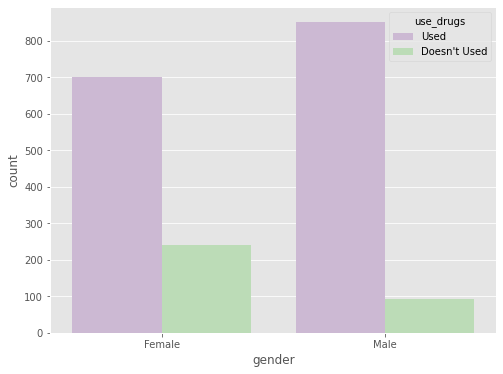

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', hue='use_drugs', data=data, palette='PRGn');

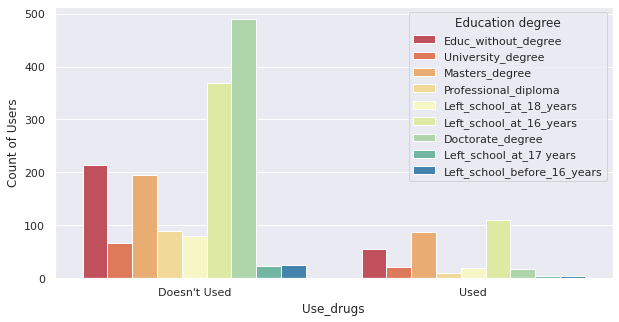

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
plot = sns.countplot(x='use_drugs',hue='education',data=data,palette='Spectral')
plot.set_xticklabels(["Doesn't Used", 'Used'])
plot.set(ylabel = 'Count of Users', xlabel='Use_drugs')
plt.legend(title='Education degree', loc='upper right', labels=list(data['education'].value_counts().index));

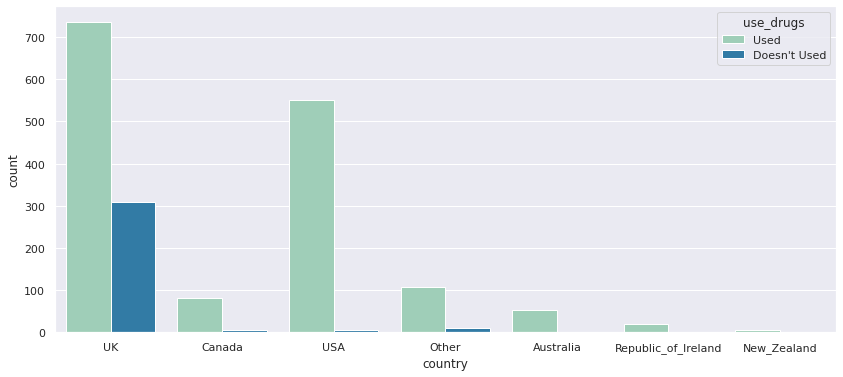

In [ ]:
plt.figure(figsize=(14, 6))
sns.countplot(x='country', hue='use_drugs', data=data, palette='YlGnBu')
plt.legend(title='use_drugs', loc='upper right');

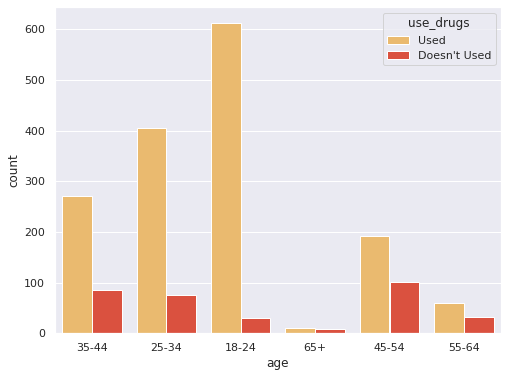

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='age', hue='use_drugs', data=data, palette='YlOrRd');

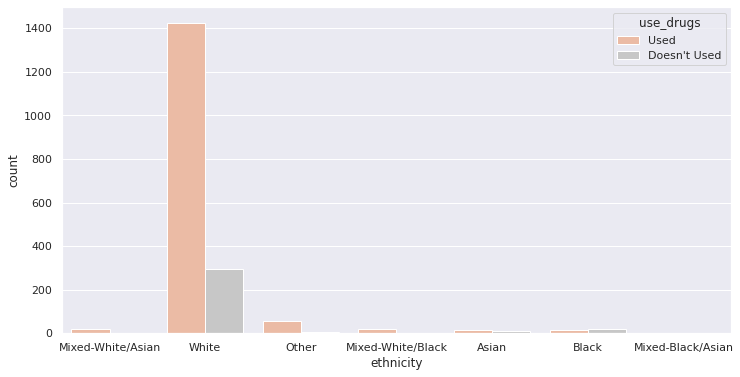

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='ethnicity', hue='use_drugs', data=data, palette='RdGy')
plt.legend(title='use_drugs', loc='upper right');

# Models

In [ ]:
data['use_drugs'] = data['use_drugs'].replace({'Used': 1, "Doesn't Used": 0})

In [ ]:
def encoder(df, column):
    le = preprocessing.LabelEncoder()
    le.fit(list(df[column]))
    le.transform(list(df[column]))
    return pd.DataFrame(le.transform(list(df[column])))

In [ ]:
data['age'] = encoder(data, 'age')
data['gender'] = encoder(data, 'gender')
data['education'] = encoder(data, 'education')
data['country'] = encoder(data, 'country')
data['ethnicity'] = encoder(data, 'ethnicity')

In [ ]:
data.head(3)

,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation,use_drugs
0,2,0,7,5,3,39,36,50,37,42,1,8,1
1,1,1,0,5,6,29,52,55,38,41,2,2,1
2,2,1,7,5,6,31,45,40,32,34,3,1,1


In [ ]:
X = data.drop('use_drugs', axis=1)
y = data['use_drugs']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

Посмотрим на соотношение классов в датасете:

In [ ]:
data['use_drugs'].value_counts()

1    1553
0     332
Name: use_drugs, dtype: int64

Видно, что классы несбалансированы. Будем максимизировать метрику precision, она хорошо справляется в задачах с подобным соотношением классов, что не скажешь про похожую метрику accuracy

### Model 1 (Baseline)

Первым делом запустим бейзлайн модель - будем предсказывать самый популярный класс

In [ ]:
popular_class = data['use_drugs'].value_counts().index[0]
y_pred_base = np.array([popular_class]  * len(y_test))

In [ ]:
precision_score(y_test, y_pred_base)

0.8275862068965517

### Model 2 (Логистическая регрессия)

In [ ]:
model_logreg = LogisticRegression(random_state=42, class_weight={0: 5, 1: 1})
model_logreg.fit(X_train, y_train)
y_pred_logreg = model_logreg.predict(X_test)
precision_score(y_test, y_pred_logreg)

0.9273504273504274

### Model 3 (Случайный лес)

In [ ]:
model_rfc = RandomForestClassifier(random_state=42)
model_rfc.fit(X_train, y_train)
y_pred_rfc = model_rfc.predict(X_test)
precision_score(y_test, y_pred_rfc)

0.8629737609329446

In [ ]:
def feature_import(model, color):
    feats = {}
    for feature, importance in zip(data.columns, model.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    sns.set(font_scale = 3)
    sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
    fig, ax = plt.subplots()
    fig.set_size_inches(7,5)
    sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color=color)
    plt.xlabel('Importance', fontsize=14, weight = 'bold')
    plt.ylabel('Features', fontsize=14, weight = 'bold')
    plt.title('Feature Importance', fontsize=16, weight = 'bold');

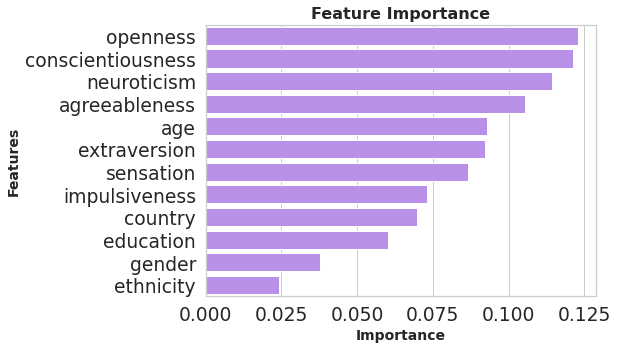

In [ ]:
feature_import(model_rfc, "#B881F7")

### Model 4 (Градиентный бустинг от XGBoost)

In [ ]:
model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)
precision_score(y_test, y_pred_xgb)

0.8584070796460177

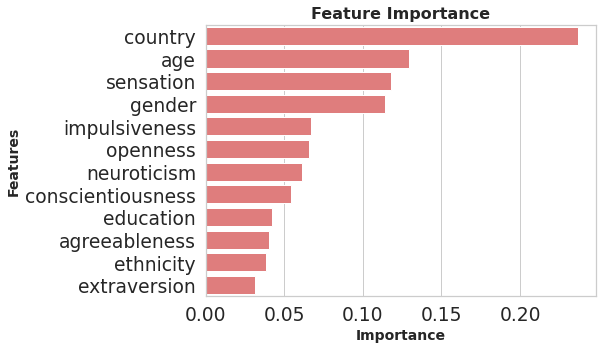

In [ ]:
feature_import(model_xgb, "#F06C6C")

### Model 5 (Градиентный бустинг от LightGBM)

In [ ]:
model_lgbm = LGBMClassifier(random_state=42)
model_lgbm.fit(X_train, y_train)
y_pred_lgbm = model_lgbm.predict(X_test)
precision_score(y_test, y_pred_lgbm)

0.8738461538461538

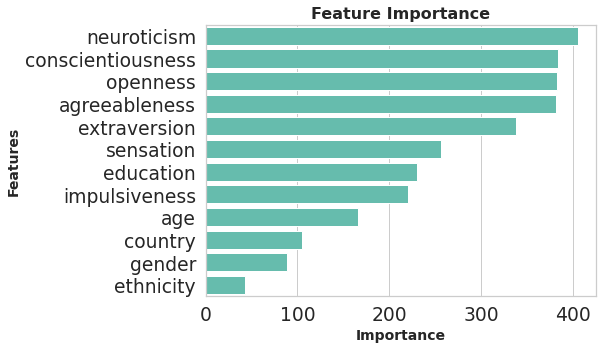

In [ ]:
feature_import(model_lgbm, "#57CBB6")

### Model 6 (Градиентный бустинг от Яндекса)

In [ ]:
model_cbc = CatBoostClassifier(random_state=42, silent=True)
model_cbc.fit(X_train, y_train)
y_pred_cbc = model_cbc.predict(X_test)
precision_score(y_test, y_pred_cbc)

0.8746268656716418

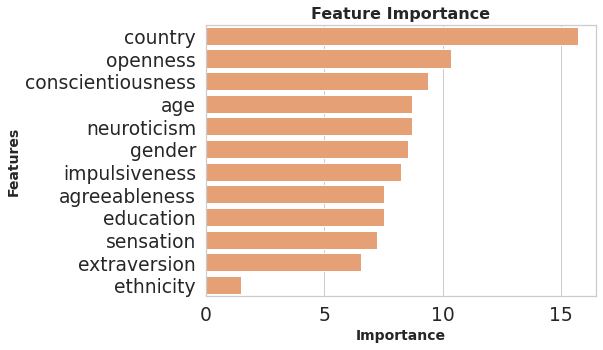

In [ ]:
feature_import(model_cbc, "#F89D62")

**Мини-Вывод**: самой лучшей моделью оказалась логистическая регрессия, попробуем дальше чуть-чуть улучшить эту модель

### Логистическая регрессия

feature engineering: Попробуем перемножить между собой некоторые признаки, а какие-то возвести в квадрат

In [ ]:
data['gender_ethnicity'] = data['gender'] * data['ethnicity']
data['ethnicity * ethnicity'] = data['ethnicity'] * data['ethnicity']

In [ ]:
X_fe = data.drop('use_drugs', axis=1)
y_fe = data['use_drugs']

In [ ]:
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_fe, y_fe, train_size=0.8, test_size=0.2, random_state=42)

In [ ]:
model_logreg_fe = LogisticRegression(random_state=42, class_weight={0: 5, 1: 1})
model_logreg_fe.fit(X_train_fe, y_train_fe)
y_pred_logreg_fe = model_logreg_fe.predict(X_test_fe)
precision_score(y_test_fe, y_pred_logreg_fe)

0.9356223175965666

**ВЫВОД**: Данная задача была сведена к бинарной классификации, в которой уже была проведена предобработка данных, визуальный анализ признаков от таргет переменной и далее построение множества моделей и выбора лучшей из них. Лучшей оказалась **логистическая регрессия** и показала качество метрики **precision = 0.9356**

###**Задание №4.** Предположим, что мы построили рекомендательную систему, и ожидаем, что средний чек клиента вследствие этого должен вырасти. Мы провели AB-тест и собрали данные по контрольной и тестовой группе. Предложите и проведите статистический тест, который можно применить к этим данным.
В процессе выполнения задания разрешено пользоваться библиотеками scipy и statsmodels.

In [ ]:
import numpy as np
from scipy.stats import ttest_ind

# Сгенерируем данные для задачи
control = np.random.lognormal(mean=5, sigma=2, size=(100000,))
test = np.random.lognormal(mean=5.04, sigma=2, size=(100000,))

Будем проводить **t-критерий Стьюдента** для проверки различия между выборками. Нулевая гипотеза предполагает, что разница между средними значениями показателя в выборках незначительна. Альтернативная гипотеза предполагает наличие существенной разницы между средними значениями.Уровень значимости α = 0,05.

In [ ]:
pd.Series(control).describe()

count    100000.000000
mean       1099.804352
std        6247.216626
min           0.055449
25%          38.134044
50%         147.330426
75%         574.817999
max      540216.828193
dtype: float64

In [ ]:
pd.Series(test).describe()

count    100000.000000
mean       1101.586694
std        6083.896311
min           0.029479
25%          39.820482
50%         154.136661
75%         594.421014
max      688725.173798
dtype: float64

In [ ]:
ttest_ind(control, test)

Ttest_indResult(statistic=-0.064634699476046, pvalue=0.9484649208741254)

Как видим - различия статистически не значимы

Попробуем воспользоваться также онлайн-калькулятором:

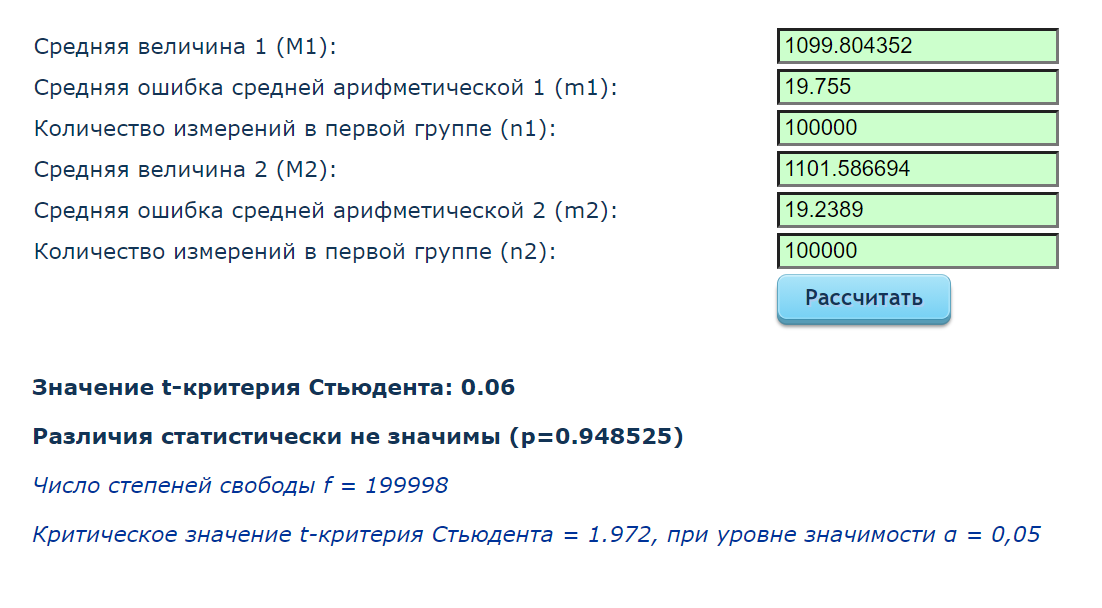

Ссылка на калькулятор: https://medstatistic.ru/calculators/averagestudent.html